In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

These changes are implemented in the new architecture: GNNSAGERecommenderwithSkipConnections.  
Internally instead of using the regular GNN, uses the GNNSAGE

# Imports

In [2]:
import pandas as pd
import pickle
import numpy as np
import torch
import os
import gc

from utils.setup_nodes import create_edge_lists, create_user_df
from utils.graph_helpers import train_model_without_test, plot_train_val_loss, final_evaluation, plot_activation_heatmap_and_density
from utils.graph_model import GNNSAGERecommenderwithSkipConnections
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, get_top_k_preds

# Set up

In [3]:
seed_everything()

In [4]:
user_split = "train_test"
prod_embed_name = "meta_features_512"
user_embed_name = "user_reviews_features_512"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"
results_folder = "final_model"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

# Load data

In [5]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [6]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

In [7]:
# Add the embedding 
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Make super user df
user_df = create_user_df(train_user_df, test_user_df)

In [8]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [9]:
# Concat product nodes 
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

In [10]:
# concat user nodes 
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

In [11]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU 

In [12]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Model

In [13]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
embedding_dim = 256
dropout_prob = 0.2

In [14]:
# Instantiate the model
model = GNNSAGERecommenderwithSkipConnections(num_users, num_products, user_feature_dim, product_feature_dim, embedding_dim, dropout_prob)

In [15]:
# move the model 
model.to(device)

GNNSAGERecommenderwithSkipConnections(
  (user_feature_transform): Linear(in_features=776, out_features=256, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=256, bias=True)
  (conv1): SAGEConv(256, 256, aggr=mean)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SAGEConv(256, 256, aggr=mean)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): Linear(in_features=256, out_features=1, bias=True)
)

In [16]:
# Record activations for visualization
activations = {}  # Dictionary to store activations
def hook_fn(module, input, output):
    """Hook function to capture activations."""
    activations[module] = output
hook_handle_1 = model.conv1.register_forward_hook(hook_fn)
hook_handle_2 = model.conv2.register_forward_hook(hook_fn)
hook_handle_3 = model.user_feature_transform.register_forward_hook(hook_fn)
hook_handle_4 = model.product_feature_transform.register_forward_hook(hook_fn)

# Train

In [17]:
num_epochs = 1886
lr = 0.01

In [18]:
train_losses = train_model_without_test(model, train_edge_index, train_edge_weights, user_nodes, product_nodes, num_epochs = num_epochs, lr = lr, 
                                        print_progress = True, print_freq = 100)

Epoch: 100, Train Loss: 5.1362
Epoch: 200, Train Loss: 1.8061
Epoch: 300, Train Loss: 0.5973
Epoch: 400, Train Loss: 0.3159
Epoch: 500, Train Loss: 0.1611
Epoch: 600, Train Loss: 0.1098
Epoch: 700, Train Loss: 0.1278
Epoch: 800, Train Loss: 0.0996
Epoch: 900, Train Loss: 0.1309
Epoch: 1000, Train Loss: 0.0936
Epoch: 1100, Train Loss: 0.1048
Epoch: 1200, Train Loss: 0.0886
Epoch: 1300, Train Loss: 0.1001
Epoch: 1400, Train Loss: 0.0847
Epoch: 1500, Train Loss: 0.0823
Epoch: 1600, Train Loss: 0.0800
Epoch: 1700, Train Loss: 0.0879
Epoch: 1800, Train Loss: 0.0791


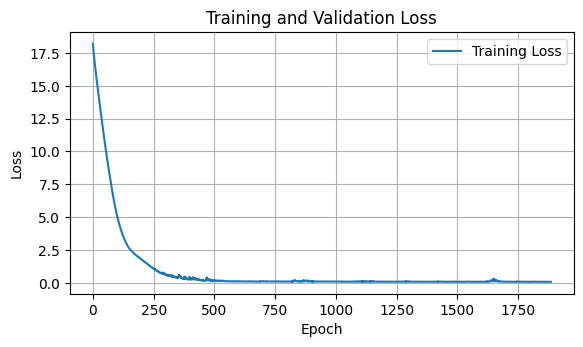

In [19]:
plot_train_val_loss(train_losses)

In [20]:
os.makedirs(f"results/{results_folder}", exist_ok=True)
torch.save(train_losses, f"results/{results_folder}/train_loss.pt")

pickle.dump(activations, open(f"results/{results_folder}/activations.pkl", "wb"))

# Test

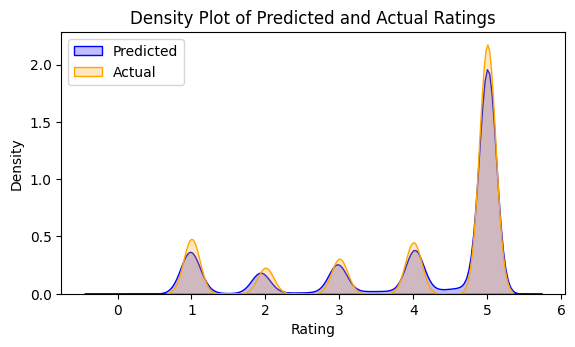

0.07579642534255981


In [21]:
test_loss, predictions = final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device, plot = True, print_test = False)
print(test_loss.item())

In [22]:
torch.save(predictions, f"results/{results_folder}/predictions.pt")
torch.save(model.state_dict(), f"results/{results_folder}/model.pt")

# Recomendations 

In [23]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [24]:
# The pure random 
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: 15ml Magic Soak-Off Gel Nail Polish Remover, Professional Remover Nail Polish Delete Primer Acrylic Clean Degreaser For Nail Art Lacquer, Easily & Quickly
Product 2: Gel Nail Polish Remover, Soak-Off Gel Polish Remover Professional Removes Soak-Off Gel Polish In 2-5 Minutes Easily & Quickly Don't Hurt Your Nails
Product 3: Magic Roller Ball Toy, Dog Cat Pet Toy Automatic Roller Ball Magic Ball (1 Rolling Ball + 4 Color Ball Cover)
Product 4: Magic Nail Polish Remover (2 Pack) - Remove Gel Nail Polish Within 2-3 Minutes - Quick & Easy Polish Remover - No Need For Foil, Soaking Or Wrapping, 0.5 Fl Oz
Product 5: Nail Repair, Nail Repair Pen, Natural Nail Treatment, Maximum Strength Nail Solution, Perfect for Strengthening Unhealthy Nails, 4 Pens
Product 6: Jagua Tattoo Kit Freehand Ink Temporary Tattoo Kit 3 Bottles Semi Permanent Tattoo DIY Temp Tattoos for Women Kids Men Fake Tattoos Freckles 30 Pcs Tattoo Stencils
Product 7: Aliver Magic Nail Polish Remover, Professional Soa

In [25]:
# The user with some data 
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [26]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Maven Thread 2 Count Hair Scrunchies Elastic Hair Bands Scrunchy Hair Ties Accessories for Women or Girls Red and Blue BANDANA Set
Product 2: BGGME 100% 25mm Siberian Mink Fur Eyelashes Stackable & Reusable 2pairs for 1 package Luxury Case (S2002)
Product 3: SHINEE JONGHYUN - Collection [THE STORY] Op.2 CD+Photo Booklet Sealed K-POP
Product 4: JIMIRE 3D Mink Lashes Dramatic Volume Lashes 100% Siberian Mink Fur Eyelashes 1 Pair
Product 5: Maven Thread 2 Count Hair Scrunchies Elastic Hair Bands Scrunchy Hair Ties Accessories for Women or Girls Heather Grey Shibori Black and White - SHADOW Set
Product 6: Beyond Silence: Life, Diary, Letters of Benedetta Bianchi Porro
Product 7: Beautiful Leopard Print Scarf Wrap Stole Chiffon Faux Silk
Product 8: Mink Eyelashes 3D Mink Lashes 25mm Lashes Extension Volume Handmade Natural Eyelashes(X15) Ruairie
Product 9: JIMIRE 3D Mink Lashes Natural Volume Lashes 100% Siberian Mink Fur Eyelashes 1 Pair
Product 10: QIUTIMIY 12 Pack(Green) Lily 

In [27]:
# count more than 10 purchases
min_unique_purchase = 10
item_count_df = test_user_edges.groupby("user_id").prod_idx.apply(lambda x: len(set(x))).reset_index()
dense_user_id = item_count_df[item_count_df["prod_idx"] >= min_unique_purchase][["user_id"]]

In [28]:
user_id = dense_user_id.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

user_df[user_df.user_id == user_id]

Product 1: Beyond Silence: Life, Diary, Letters of Benedetta Bianchi Porro
Product 2: SHINEE JONGHYUN - Collection [THE STORY] Op.2 CD+Photo Booklet Sealed K-POP
Product 3: Livegain Premium Rich Protein Treatment 500ml/16.89oz
Product 4: Keo's Thai Cuisine
Product 5: ATEEZ TREASURE EP.FIN:ALL TO ACTION SPECIAL LIMITED CD+108p 1st Anniversary Photo Book+36p Treasure Photo Book +1ea Sticker+2p Photo Card+1ea Tresure Card & Film(2ea Set) +1p STORE GIFT+TRACKING CODE
Product 6: A Fighter Pilot's Story Wwii VHS
Product 7: WAYV [TAKE OVER THE MOON] 2nd Mini Album CD+1p FOLDED Poster+124 pages Booklet+1p Photo Card+1p Circle Card+1p special SM GIFT+TRACKING CODE
Product 8: Santa Maria Novella Schiuma Da Barba Shaving Foam 10.1oz
Product 9: Claudio Arrau: Birth of a Legend - Columbia Recordings USA 1946-1950
Product 10: Pot O' Gold Letterhead (Case of 1)
tensor([4.4711, 4.4584, 4.4381, 4.4278, 4.4214, 4.3980, 4.3929, 4.3857, 4.3857,
        4.3823], device='cuda:0')


,user_id,rating_mean,rating_count,helpful_vote_mean,helpful_vote_gte_1,verified_purchase_mean,last_active_in_days_min,last_active_in_days_max,word_count_mean,embedding
10412,AE5IMGWRBJA7JQFBQTBK25HDYGVA,3.2,5,0.0,0,0.0,328,354,84.6,"[0.3325386, -0.044216163, 0.19078752, -0.24438..."


# Memory clear

In [ ]:
hook_handle_1.remove()
hook_handle_2.remove()
hook_handle_3.remove()
hook_handle_4.remove()

del dense_user_id, recommended_products, predictions, pred_ratings, existing_test_users, activations
del train_edge_index, train_edge_weights, train_losses, train_user_df, train_user_edges, train_user_embedding
del test_edge_index, test_edge_weights, test_loss, test_user_df, test_user_embedding, user_df, user_info
del product_embedding, title_mapping, user_id_to_idx, item_count_df, prod_idx_to_id, product_df
torch.cuda.empty_cache()
gc.collect()

7476

# Metrics

In [30]:
product_idx_tensor = torch.tensor(list(prod_id_to_idx.values()), dtype=torch.long, device = device)
test_edges_grp = test_user_edges.groupby("user_idx").prod_idx.apply(list).reset_index()
test_edges_users = test_edges_grp.user_idx.to_list()

In [31]:
predictions = get_top_k_preds(model, test_edges_users, 10, 32, user_nodes, product_nodes, product_idx_tensor, device) # about 5 min to run
test_edges_grp["prediction"] = list(torch.vstack(predictions).cpu().numpy())
test_edges_grp["match_count"] = test_edges_grp.apply(lambda x: len(set(x.prod_idx).intersection(set(x.prediction))), axis = 1)

In [32]:
# Overall recall
(test_edges_grp["match_count"] / test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [35]:
preds = set(y.item() for x in test_edges_grp.prediction for y in x)
len(preds)

3150

In [36]:
test_edges_grp.to_parquet(f"results/{results_folder}/predictions.parquet")

In [ ]:
torch.save(test_edge_weights, "plot_helpers/train_test_edge_weights.pt")